In [1]:
#PROGRAMA PARA DETECÇÃO DE FONTES
from astropy.stats import sigma_clipped_stats
import scipy.ndimage as ndi
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

In [2]:
#Importar imagem
GHII = 'UM455_full.fits'
fits.info(GHII)

data = fits.open(GHII)
data = data[0].data

#Estatística de sigma cortado
mean , median , std = sigma_clipped_stats ( data , sigma = 3. )  
print (( mean , median , std ))  #média, mediana e desvio padrão

Filename: UM455_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (996, 2048)   float32   
(0.30143327, 0.30101496, 0.02366888)


<IPython.core.display.Javascript object>


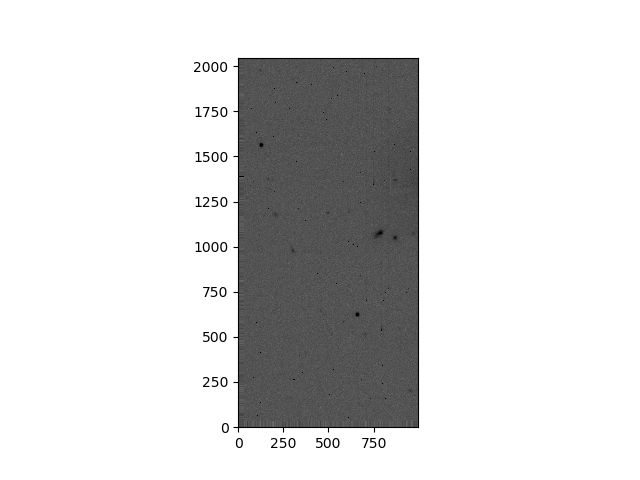

In [3]:
#Plot da Imagem
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.imshow(data, origin='lower', cmap='gray_r', norm=LogNorm(vmin=0.025, vmax=1))

<IPython.core.display.Javascript object>


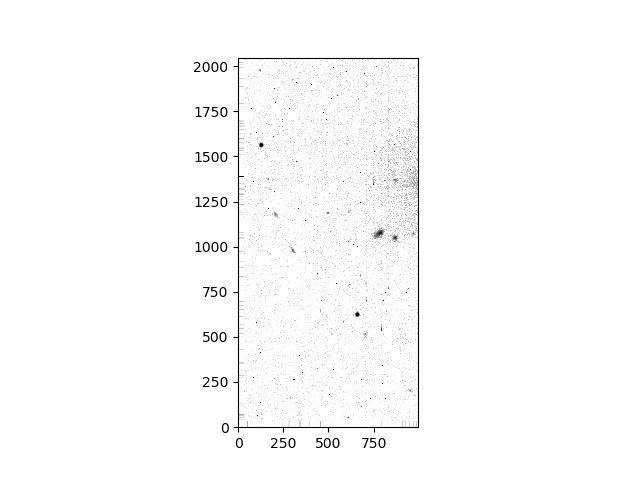

In [4]:
#Plot da imagem com background subtraido
%matplotlib notebook
data_sub = data - median
plt.imshow(data_sub, origin='lower', cmap='gray_r', norm=LogNorm(vmin=0.025, vmax=1))

In [20]:
#Subtração do background e DAOStarFinder (implementação do algoritmo DAOFIND) para encontrar as estrelas na imagem.
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=1.0, threshold=5.*std) #Estrelas com FWHMs de 3 pixels e picos aprox. 5sigma acima plano de fundo
sources = daofind(data - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.4g'  # for consistent table output
print(sources)  


 id xcentroid ycentroid sharpness roundness1 ... sky   peak    flux    mag   
--- --------- --------- --------- ---------- ... --- -------- ----- ---------
  1     925.3     28.99    0.2727      0.386 ...   0  0.03248 1.117   -0.1204
  2     987.1     28.97    0.3468    -0.1552 ...   0  0.04985 1.128   -0.1312
  3     465.6     44.68    0.3941    -0.7842 ...   0  0.03341 1.021  -0.02213
  4     43.51     73.51    0.2356     0.3612 ...   0  0.02277 1.054  -0.05663
  5     85.24     78.57    0.8435       0.56 ...   0  0.07845 1.073  -0.07657
  6     691.9     137.6    0.7749     0.7831 ...   0  0.07155  1.05  -0.05267
  7     924.9     162.9    0.5748     0.3956 ...   0  0.05789 1.064   -0.0678
  8       639     166.5     0.654     0.4612 ...   0  0.06827 1.041  -0.04375
  9     757.9     170.5    0.3559    -0.6966 ...   0      0.8 16.86    -3.067
 10     415.6       170    0.4815    -0.1434 ...   0  0.03509 1.041  -0.04403
...       ...       ...       ...        ... ... ...      ...   

In [21]:
import pandas as pd
import numpy as np
sources = np.array(sources)
table = pd.DataFrame(sources)

In [22]:
print(table)

      id   xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
0      1  925.274167    28.986187   0.272714    0.386012    0.824383    49   
1      2  987.089709    28.973290   0.346840   -0.155247    0.883943    49   
2      3  465.551651    44.680143   0.394095   -0.784189   -0.988348    49   
3      4   43.510520    73.506566   0.235597    0.361238    0.301765    49   
4      5   85.239985    78.571821   0.843477    0.560049    0.404025    49   
5      6  691.921122   137.623052   0.774922    0.783117    0.228798    49   
6      7  924.935215   162.876814   0.574831    0.395647   -0.035690    49   
7      8  639.009880   166.490801   0.654039    0.461206   -0.041384    49   
8      9  757.944231   170.537947   0.355913   -0.696626   -0.087359    49   
9     10  415.581090   169.972070   0.481501   -0.143379    0.183453    49   
10    11   43.152613   180.575783   0.315443   -0.292807    0.565020    49   
11    12  594.828494   189.952753   0.519249    0.558136    0.50

<IPython.core.display.Javascript object>


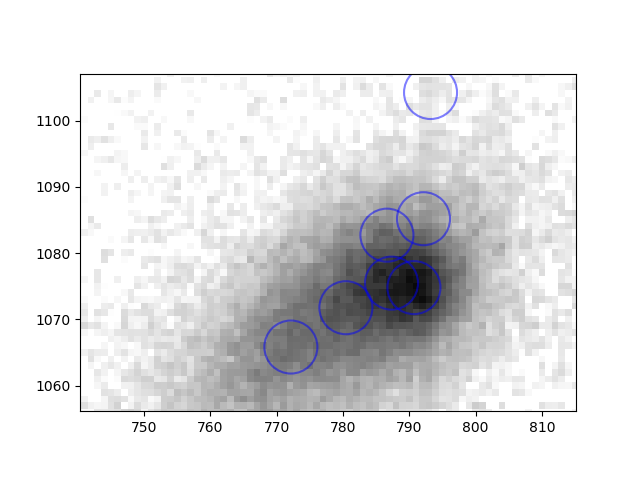

In [23]:
#Plot final da imagem com a DETECÇÃO das estrelas
%matplotlib notebook
import numpy as np
from astropy.visualization import SqrtStretch #visualizador raiz
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(vmin=0.025, vmax=1,stretch=SqrtStretch())
plt.imshow(data_sub,  origin='lower', cmap='Greys', norm=norm)
apertures.plot(color='Blue', lw=1.5, alpha=0.5)

In [38]:
#DETECÇÃO DE PICOS 
from photutils import find_peaks
import photutils

#Estatística de sigma cortado da imagem subtraida do fundo
mean , median , std = sigma_clipped_stats ( data_sub , sigma = 5. )  
print (( mean , median , std ))  #média, mediana e desvio padrão

#Calcule uma imagem de limite em pixel que pode ser usada para detectar fontes.
threshold = photutils.detect_threshold(data_sub, snr=5.0, background=None, error=None) #error=None; Se None , um valor eficaz de fundo escalar será estimado usando estatísticas cortadas por sigma. 

tbl = find_peaks(data_sub, threshold, box_size=11)
tbl['peak_value'].info.format = '%.5g'  # for consistent table output
print(tbl[:10])  # print only the first 10 peaks

(0.0007725576288066804, 0.00012359023094177246, 0.024574028328061104)
x_peak y_peak peak_value
------ ------ ----------
   346      0     2.3978
   346      1     2.3978
   346      2     2.3978
   346      3     2.3978
   346      4     2.3978
   346      5     2.3978
   346      6     2.3978
   346      7     2.3978
   346      8     2.3978
   346      9     2.3978


<IPython.core.display.Javascript object>


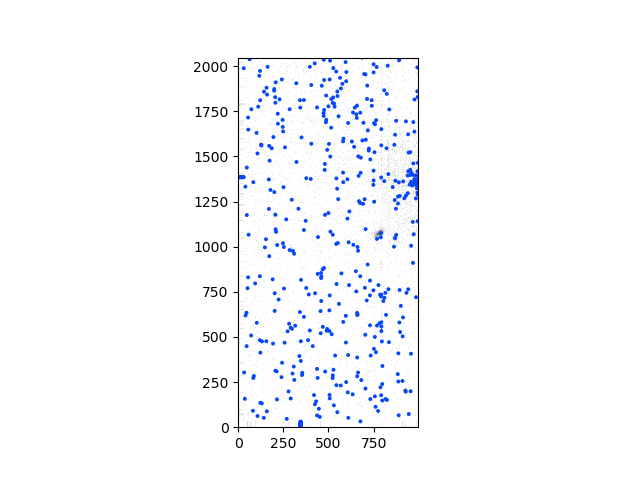

(0, 2047)

In [39]:
#PLot dos PICOS DETECTADOS
%matplotlib notebook

import numpy as np
from astropy.visualization import simple_norm

from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.)
norm = simple_norm(data_sub, 'sqrt', percent=99.9)
plt.imshow(data_sub, cmap='Greys', origin='lower',vmin=0.025, vmax=1, norm=norm)
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)